# GP Simulations 1D example

In [1]:
import sys
import math

import torch
import numpy as np
import matplotlib.pyplot as plt
import dsdl
import gpytorch
import tqdm

from torcheval.metrics import BinaryAUROC
from joblib import Parallel, delayed

sys.path.append("..")

from src._97_gpytorch import LogisticGPVI, GPModel, LogitLikelihood, PGLikelihood, LogitLikelihoodMC

%load_ext autoreload
%autoreload 2

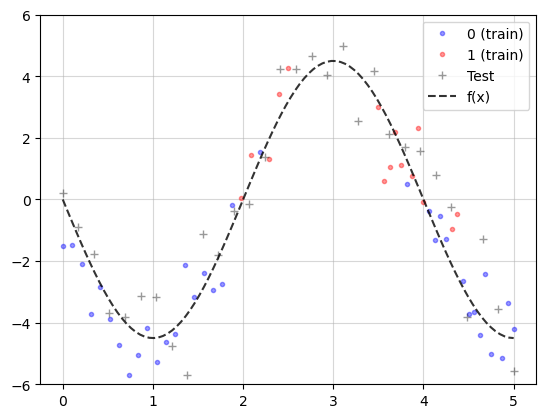

In [74]:
torch.manual_seed(1)

func = lambda x: - 4.5 * torch.sin(math.pi / 2 * x)
# func = lambda x: torch.cos(x * math.pi / 2) * 2 + torch.cos(x)

n = 50
train_x = torch.cat((torch.linspace(0, 2.5, int(n/2)), torch.linspace(3.5, 5, int(n/2))))

train_f = func(train_x) + torch.randn(train_x.shape[0]) * 1.0 # * math.sqrt(0.4)
train_x = train_x.reshape(-1, 1)
train_p = torch.sigmoid(train_f)
train_y = torch.bernoulli(train_p)

test_x = torch.linspace(0, 5, 30) 
test_f = func(test_x) + torch.randn(test_x.shape[0]) * 1.0  # * math.sqrt(0.4)
test_p = torch.sigmoid((test_f))
test_y = torch.bernoulli(test_p)

xs = torch.linspace(0, 5, 100).reshape(-1, 1)
true_f = func(xs)

id0 = train_y == 0
id1 = train_y == 1

# plt.plot(train_x.detach().numpy(), train_f.detach().numpy(), 'xk', alpha=0.4)
plt.plot(train_x[id0].detach().numpy(), train_f[id0].detach().numpy(), '.b', alpha=0.4)
plt.plot(train_x[id1].detach().numpy(), train_f[id1].detach().numpy(), '.r', alpha=0.4) 
plt.plot(test_x.detach().numpy(), test_f.detach().numpy(), '+k', alpha=0.4)
plt.plot(xs.detach().numpy(), func(xs).detach().numpy(), 'k--', alpha=0.8)
plt.grid(alpha=.5)
plt.ylim(-6, 6)
plt.legend(['0 (train)', '1 (train)', "Test", 'f(x)'])

In [75]:
f0 = LogisticGPVI(train_y, train_x, verbose=False, n_iter=1000, n_inducing=50, thresh=1e-6)
f0.fit()
print(f0.runtime)
f0.ELB0_MC()

25.16914415359497


tensor(9.6288)

In [76]:
likelihood = PGLikelihood()
f1 = LogisticGPVI(train_y, train_x, likelihood=likelihood, verbose=False, n_iter=1000, n_inducing=50, thresh=1e-6)
f1.fit()
print(f1.runtime)
f1.ELB0_MC()

16.564034938812256


tensor(8.5158)

In [77]:
likelihood = LogitLikelihoodMC()
f2 = LogisticGPVI(train_y, train_x, likelihood=likelihood, verbose=False, n_iter=1000, n_inducing=50, thresh=1e-6)
f2.fit()
print(f2.runtime)
f2.ELB0_MC()

25.58677315711975


tensor(9.2645)

In [81]:
test_x = test_x.reshape(-1, 1)
test_y = test_y.squeeze()

def eval_method(f, test_x, test_y, name):
    auc = BinaryAUROC()
    print("\n" + name)
    f_pred = f.model(xs).mean
    f_lower, f_upper = f.model(test_x).confidence_region()
    print( auc.update(f.predict(test_x), test_y).compute().item())
    print( f.neg_log_likelihood().item())
    print( ((true_f.reshape(-1) - f_pred) ** 2).mean().item() )
    print( f.ELB0_MC().item() )

for f, name in zip([f0, f1, f2], ["PB", "PG", "MC"]):
    eval_method(f, test_x, test_y, name)



PB
0.9665071770334929
13.639305114746094
4.051334857940674
9.724714279174805

PG
0.9665071770334929
14.032905578613281
2.4682724475860596
8.58491039276123

MC
0.9665071770334929
13.584577560424805
4.352729320526123
9.287642478942871


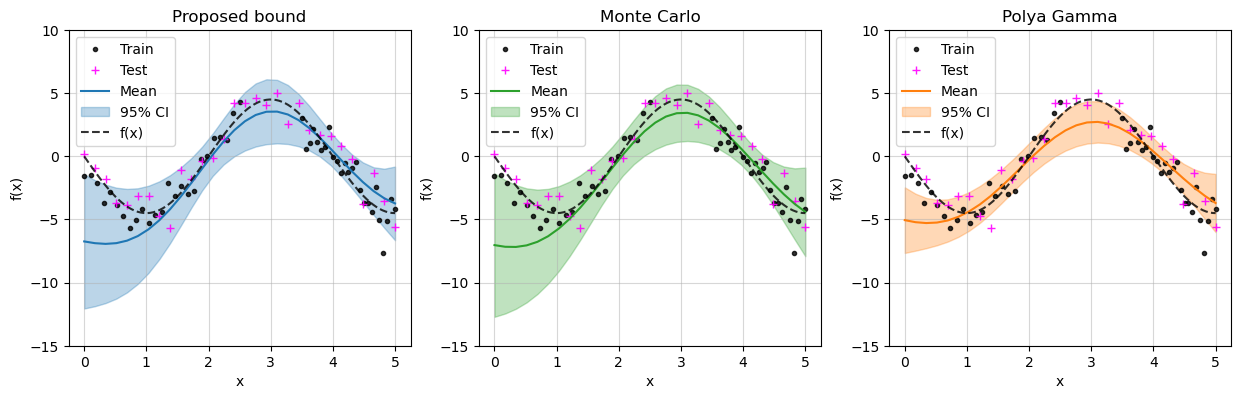

In [91]:
# x = torch.sort(torch.cat((train_x, test_x)), dim=0)[0]
def plot_gp(f, test_x, test_f, train_x, train_f, xs, true_f, ax, name, col):
    f_pred = f.model(test_x).mean
    f_lower, f_upper = f.model(test_x).confidence_region()

    ax.plot(train_x.numpy(), train_f.numpy(), '.', color="black", alpha=0.8)
    ax.plot(test_x.numpy(), test_f.numpy(), "+", color="magenta", alpha=0.9)

    ax.plot(test_x.numpy(), f_pred.numpy(), color=col)
    ax.fill_between(test_x.squeeze(1).numpy(), f_lower.numpy(), f_upper.numpy(), alpha=0.3, color=col)

    ax.plot(xs, true_f.detach().numpy(), 'k--', alpha=0.8)

    ax.set_ylim([-15, 10])
    ax.grid(alpha=.5)
    ax.set_title(name)
    ax.set_ylabel("f(x)")
    ax.set_xlabel("x")
    ax.legend(["Train", "Test", "Mean", "95% CI", "f(x)"])

names = ["Proposed bound", "Monte Carlo", "Polya Gamma"]
cols = ["C0", "C2", "C1"]
fs = [f0, f2, f1]

with torch.no_grad():
    _, ax = plt.subplots(1, 3, figsize=(15.0, 4.1))

    for axis, f, name, col in zip(ax, fs, names, cols):
        plot_gp(f, test_x, test_f, train_x, train_f, xs, true_f, axis, name, col)
    
    plt.savefig("../../papers/logistic_vb/figures/gp.pdf", bbox_inches='tight')

In [83]:
f0_lower, f0_upper = f0.credible_intervals(train_x)
f1_lower, f1_upper = f1.credible_intervals(train_x)
f2_lower, f2_upper = f2.credible_intervals(train_x)

print( torch.sum( (train_f > f0_lower) & (train_f < f0_upper) ) / train_x.shape[0] )
print( torch.sum( (train_f > f1_lower) & (train_f < f1_upper) ) / train_x.shape[0] )
print( torch.sum( (train_f > f2_lower) & (train_f < f2_upper) ) / train_x.shape[0] )

tensor(0.9200)
tensor(0.7000)
tensor(0.9200)


In [84]:
f0_lower, f0_upper = f0.credible_intervals(test_x)
f1_lower, f1_upper = f1.credible_intervals(test_x)
f2_lower, f2_upper = f2.credible_intervals(test_x)


print( torch.sum( (test_f > f0_lower) & (test_f < f0_upper) ) / test_x.shape[0] )
print( torch.sum( (test_f > f1_lower) & (test_f < f1_upper) ) / test_x.shape[0] )
print( torch.sum( (test_f > f2_lower) & (test_f < f2_upper) ) / test_x.shape[0] )

tensor(0.8333)
tensor(0.6333)
tensor(0.8667)


In [181]:
print( f0.log_marginal(test_x, test_y).item() )
print( f1.log_marginal(test_x, test_y).item() )
print( f2.log_marginal(test_x, test_y).item() )

print( f0.log_marginal(train_x, train_y).item() )
print( f1.log_marginal(train_x, train_y).item() )
print( f2.log_marginal(train_x, train_y).item() )

16.77099609375
16.840957641601562
16.762968063354492
71.37776947021484
71.35160064697266
71.38838195800781


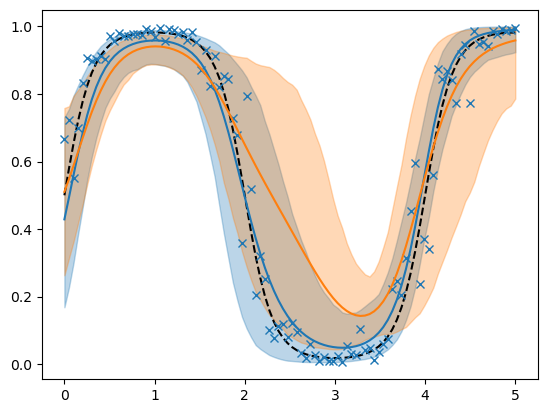

In [36]:
p_true = torch.sigmoid(func(test_x))

samp = f0.model(test_x).sample(torch.Size([1000]))
p0 = torch.sigmoid(samp)

samp = f1.model(test_x).sample(torch.Size([1000]))
p1 = torch.sigmoid(samp)

plt.plot(test_x.numpy(), p_true.numpy(), 'k--')
plt.plot(test_x.numpy(), test_p.numpy(), "x")

plt.plot(test_x.numpy(), p0.mean(dim=0).numpy(), color='tab:blue')
plt.fill_between(test_x.squeeze(1).numpy(), p0.quantile(0.025, dim=0).numpy(), p0.quantile(0.975, dim=0).numpy(), alpha=0.3, color='tab:blue')

plt.plot(test_x.numpy(), p1.mean(dim=0).numpy(), color='tab:orange')
plt.fill_between(test_x.squeeze(1).numpy(), p1.quantile(0.025, dim=0).numpy(), p1.quantile(0.975, dim=0).numpy(), alpha=0.3, color='tab:orange')

In [96]:
# full exp run in _07_gp_simulations

res = torch.load("../results/gp.pt")
res.mean(dim=1)

tensor([[16.3138,  0.7389,  2.5016,  4.3592, 16.5715, 19.5365, 16.5735, 19.5333,
         12.7481, 16.8804,  0.7352,  0.7248],
        [27.7371,  0.7431,  2.6108,  4.4645, 16.2116, 19.7069, 16.2130, 19.7120,
         12.3953, 17.2778,  0.7502,  0.7370],
        [18.8121,  0.7263,  2.8422,  3.1210, 17.2232, 20.1802, 17.2225, 20.1866,
         12.5965, 16.0544,  0.5646,  0.5484]])

In [97]:
def sf(x, n):
     return '{:g}'.format(float('{:.{p}g}'.format(x, p=n)))

def seconds_to_hms(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    time_components = []

    if hours:
        time_components.append("{}h".format(int(hours)))
    if minutes:
        time_components.append("{}m".format(int(minutes)))
        
    time_components.append("{}s".format(sf(seconds, 2)))

    # Join the components and format as a string
    result = " ".join(time_components)

    return result

In [99]:
# func.runtime, auc, mse, ci_width, \
#             func.neg_log_likelihood().item(), func.neg_log_likelihood(test_x, test_y).item(), \
#             func.log_marginal().item(),             func.log_marginal(test_x, test_y).item(), \
#             func.ELB0_MC().item(),                       func.ELB0_MC(test_x, test_y).item(), \
#             coverage_f.item(), coverage_p.item()

metric_order = [2, 1, -4, -3, 3, -2, 0]
rm = res.median(dim=1)[0]
rl = res.quantile(0.025, dim=1)
ru = res.quantile(0.975, dim=1)
for j in [0, 1, 2]:
    line = ""
    line_comp = [] 
    for i in metric_order:
        if i != 0:
            # line_comp.append(f"{sf(rm[j, i], 3)} ({sf(sd[j, i],  2)})")
            line_comp.append(f"{sf(rm[j, i], 3)} ({sf(rl[j, i],  2)}, {sf(ru[j, i],  2)})")
        else:
            # line_comp.append(f"{seconds_to_hms(float(rm[j, i]))} ({seconds_to_hms(float(sd[j, i]))})")
            line_comp.append(f"{seconds_to_hms(float(rm[j, i]))} ({seconds_to_hms(float(rl[j, i]))}, {seconds_to_hms(float(ru[j, i]))})")
    line += " & ".join(line_comp) + " \\\\"
    print(line)
print()

1.91 (0.53, 7.2) & 0.754 (0.59, 0.83) & 12.8 (1.9, 25) & 14.8 (5.9, 36) & 4.19 (2.8, 6.5) & 0.78 (0.29, 0.94) & 15s (4.5s, 32s) \\
1.92 (0.41, 7.6) & 0.76 (0.59, 0.84) & 12.3 (1.5, 23) & 15.7 (5.9, 35) & 4.31 (2.9, 6.8) & 0.8 (0.33, 0.94) & 32s (3.7s, 35s) \\
2.16 (0.58, 8.8) & 0.751 (0.53, 0.82) & 12.2 (1.3, 28) & 14 (5.3, 33) & 3.12 (2, 3.8) & 0.58 (0.16, 0.82) & 18s (6s, 30s) \\

